In [1]:
import torch
from torch.optim import Adam, Optimizer
from my_dataset import MyDataset, get_dataset_paths, count_clouds_class
from torch.utils.data import DataLoader
from CDFM3SF import CDFM3SF
from saver import Saver
import torchvision.transforms as tr
import torch.nn as nn
import matplotlib.pyplot as plt
from my_transforms import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Device in use: ", device)

Device in use:  cuda


In [3]:
def train(model, loader, optimizer: Optimizer, loss_fn, saver: Saver, n_epochs=1):
    model.train()

    for epoch in range(n_epochs):
        loss_list = []
        for data, label in loader:
            print("ciao")
            optimizer.zero_grad()

            data_10m, data_20m, data_60m = data

            data_10m = data_10m.to(device)
            data_20m = data_20m.to(device)
            data_60m = data_60m.to(device)
            label = label.to(device)

            output1, output2, output3 = model(data_10m, data_20m, data_60m)
            loss: torch.Tensor = loss_fn(output1, output2, output3, label)

            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

            if len(loss_list) % 1000 == 0:
                mean_loss = sum(loss_list) / len(loss_list)
                saver.save(mean_loss, epoch)
                print(f'Epoch: {epoch}, loss: {mean_loss}')
                loss_list = []

In [4]:
train_paths, _ = get_dataset_paths()

In [5]:
transform = tr.Compose([
    MyToTensor(),
    MyRandomVerticalFlip(p=0.5),
    MyRandomHorizontalFlip(p=0.5),
    MyRandomRotation(degrees=90)
])

train_dataset = MyDataset(train_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [6]:
n_clouds, n_background = count_clouds_class(train_paths)
print(f"Clouds: {n_clouds}, Backgrounds: {n_background}")

Clouds: 20925490, Backgrounds: 440464334


In [7]:
def my_loss(output1, output2, output3, label) -> torch.Tensor:
    output1 = output1.squeeze(1)
    output2 = output2.squeeze(1)
    output3 = output3.squeeze(1)
    label = label.squeeze(1)

    label1 = label
    label2 = tr.Resize((192, 192), antialias=False)(label)
    label3 = tr.Resize((64, 64), antialias=False)(label)

    weight = torch.Tensor([n_background/n_clouds]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(weight=weight)

    loss1 = loss_fn(output1, label1)
    loss2 = loss_fn(output2, label2)
    loss3 = loss_fn(output3, label3)

    return 1*loss1 + 0.1*loss2 + 0.01*loss3

In [8]:
model = CDFM3SF([4, 6, 3], gf_dim=64)
model = model.to(device)

In [9]:
saver = Saver(model)
saver.load()

In [10]:
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.5, 0.9))

In [11]:
train(model, train_loader, optimizer, my_loss, saver, n_epochs=1)

ciao
ciao
ciao
ciao


KeyboardInterrupt: 

In [12]:
def show_example(loader):
    (d10m, d20m, d60m), label = next(iter(loader))
    d10m = d10m.to(device)
    d20m = d20m.to(device)
    d60m = d60m.to(device)
    label = label.to(device)

    out = model(d10m, d20m, d60m)

    number_of_examples = label.shape[0]

    fig, axs = plt.subplots(number_of_examples, 6, figsize=(15, 7))
    for i in range(number_of_examples):
        axs[i][0].imshow(out[0].cpu()[i][0].detach().numpy())
        axs[i][1].imshow(out[1].cpu()[i][0].detach().numpy())
        axs[i][2].imshow(out[2].cpu()[i][0].detach().numpy())

        result = torch.sigmoid(out[0].cpu()[i][0].detach()).numpy()
        axs[i][3].imshow(result, cmap='gray', vmin=0, vmax=1)

        result[result < 0.5] = 0
        result[result >= 0.5] = 1
        axs[i][4].imshow(result, cmap='gray', vmin=0, vmax=1)

        axs[i][5].imshow(label.cpu()[i][0].detach().numpy(), cmap='gray')

    axs[0, 0].set_title('10m')
    axs[0, 1].set_title('20m')
    axs[0, 2].set_title('60m')
    axs[0, 3].set_title('final')
    axs[0, 4].set_title('final trhesholded')
    axs[0, 5].set_title('label')
    
    plt.show()

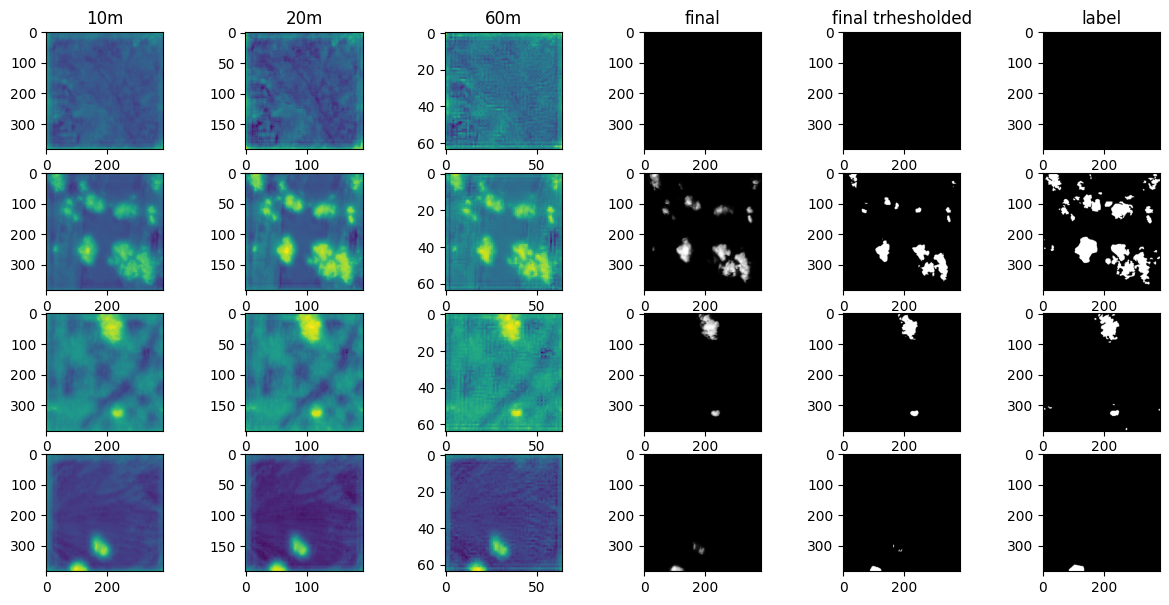

In [21]:
show_example(train_loader)